In [ ]:
from skimage import data, io, segmentation, color
from skimage.future import graph
from matplotlib import pyplot as plt
from skimage.measure import regionprops
from skimage import draw
import numpy as np
 
from sklearn.datasets import load_digits
def show_img(img):
    width = 10.0
    height = 10.0
    height = img.shape[0]*width/img.shape[1]
    f = plt.figure(figsize=(width, height))
    plt.imshow(img,cmap='gray_r')
    #return ()
 

def display_edges(image, g, threshold):
    """Draw edges of a RAG on its image
 
    Returns a modified image with the edges drawn.Edges are drawn in green
    and nodes are drawn in yellow.
 
    Parameters
    ----------
    image : ndarray
        The image to be drawn on.
    g : RAG
        The Region Adjacency Graph.
    threshold : float
        Only edges in `g` below `threshold` are drawn.
 
    Returns:
    out: ndarray
        Image with the edges drawn.
    """
    image = image.copy()
    #print(g.edges)
    for edge in g.edges:
        #print(edge)
        n1, n2 = edge
 
        r1, c1 = map(int, rag.nodes[n1]['centroid'])
        r2, c2 = map(int, rag.nodes[n2]['centroid'])
 
        line  = draw.line(r1, c1, r2, c2)
        circle = draw.circle(r1,c1,2)
        #print(image[circle])
 
        if g[n1][n2]['weight'] < threshold:
            image[line] = 0,1,0
        image[circle] = 1,1,0
 
    return image

In [ ]:
import os

import torch
from torch_geometric.data import (InMemoryDataset, Data, download_url,
                                  extract_tar)


class MNISTSuperpixels(InMemoryDataset):
    r"""MNIST superpixels dataset from the `"Geometric Deep Learning on
    Graphs and Manifolds Using Mixture Model CNNs"
    <https://arxiv.org/abs/1611.08402>`_ paper, containing 70,000 graphs with
    75 nodes each.
    Every graph is labeled by one of 10 classes.
    Args:
        root (string): Root directory where the dataset should be saved.
        train (bool, optional): If :obj:`True`, loads the training dataset,
            otherwise the test dataset. (default: :obj:`True`)
        transform (callable, optional): A function/transform that takes in an
            :obj:`torch_geometric.data.Data` object and returns a transformed
            version. The data object will be transformed before every access.
            (default: :obj:`None`)
        pre_transform (callable, optional): A function/transform that takes in
            an :obj:`torch_geometric.data.Data` object and returns a
            transformed version. The data object will be transformed before
            being saved to disk. (default: :obj:`None`)
        pre_filter (callable, optional): A function that takes in an
            :obj:`torch_geometric.data.Data` object and returns a boolean
            value, indicating whether the data object should be included in the
            final dataset. (default: :obj:`None`)
    """

    url = ('https://graphics.cs.tu-dortmund.de/fileadmin/ls7-www/misc/cvpr/'
           'mnist_superpixels.tar.gz')

    def __init__(self, root, train=True, transform=None, pre_transform=None,
                 pre_filter=None):
        super(MNISTSuperpixels, self).__init__(root, transform, pre_transform,
                                               pre_filter)
        path = self.processed_paths[0] if train else self.processed_paths[1]
        self.data, self.slices = torch.load(path)

    @property
    def raw_file_names(self):
        return ['training.pt', 'test.pt']

    @property
    def processed_file_names(self):
        return ['training.pt', 'test.pt']

    def download(self):
        path = download_url(self.url, self.raw_dir)
        extract_tar(path, self.raw_dir, mode='r')
        os.unlink(path)

    def process(self):
        for raw_path, path in zip(self.raw_paths, self.processed_paths):
            x, edge_index, edge_slice, pos, y = torch.load(raw_path)
            edge_index, y = edge_index.to(torch.long), y.to(torch.long)
            m, n = y.size(0), 75
            x, pos = x.view(m * n, 1), pos.view(m * n, 2)
            node_slice = torch.arange(0, (m + 1) * n, step=n, dtype=torch.long)
            graph_slice = torch.arange(m + 1, dtype=torch.long)
            self.data = Data(x=x, edge_index=edge_index, y=y, pos=pos)
            self.slices = {
                'x': node_slice,
                'edge_index': edge_slice,
                'y': graph_slice,
                'pos': node_slice
            }

            if self.pre_filter is not None:
                data_list = [self.get(idx) for idx in range(len(self))]
                data_list = [d for d in data_list if self.pre_filter(d)]
                self.data, self.slices = self.collate(data_list)

            if self.pre_transform is not None:
                data_list = [self.get(idx) for idx in range(len(self))]
                data_list = [self.pre_transform(data) for data in data_list]
                self.data, self.slices = self.collate(data_list)

            torch.save((self.data, self.slices), path)

Extracting PATH_TO_STORE_TRAINSET/stl10_binary.tar.gz to PATH_TO_STORE_TRAINSET


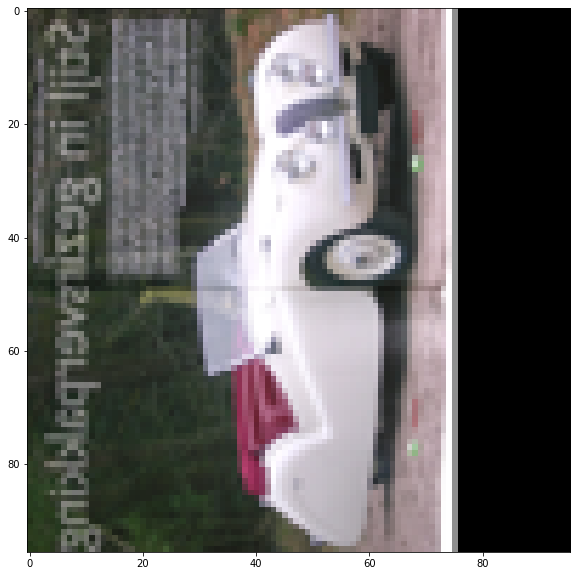

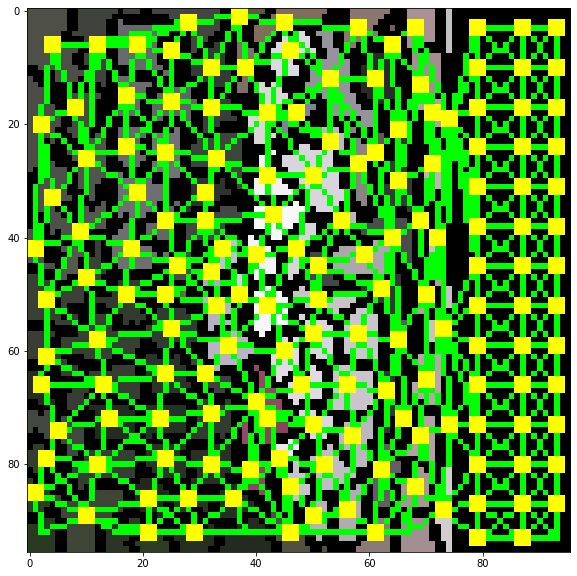

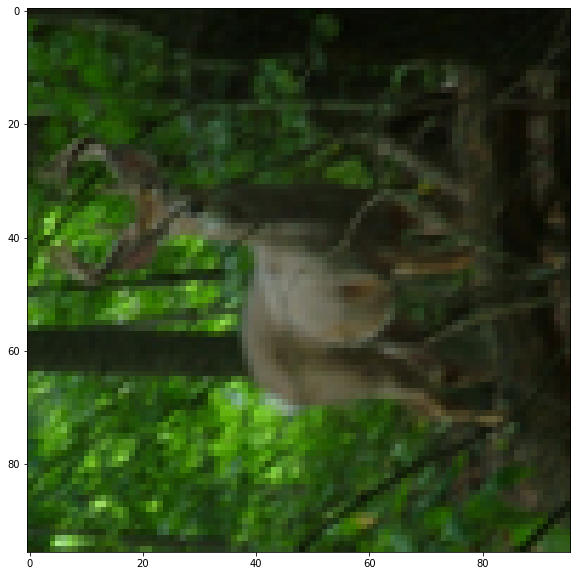

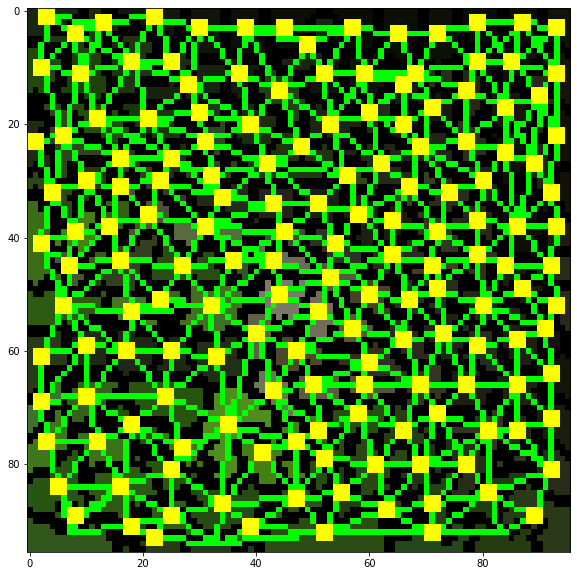

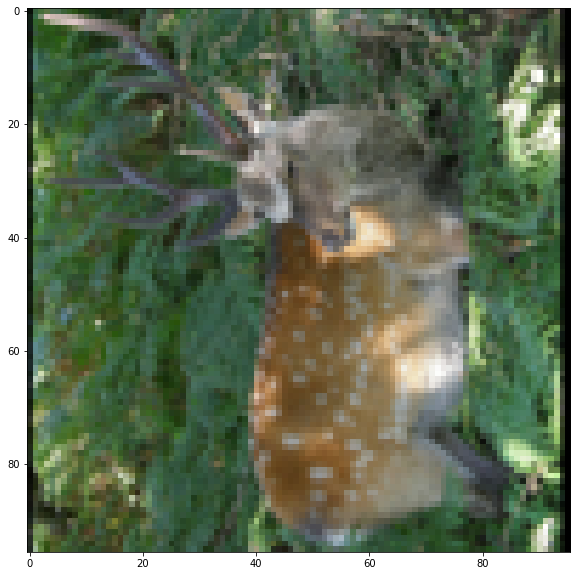

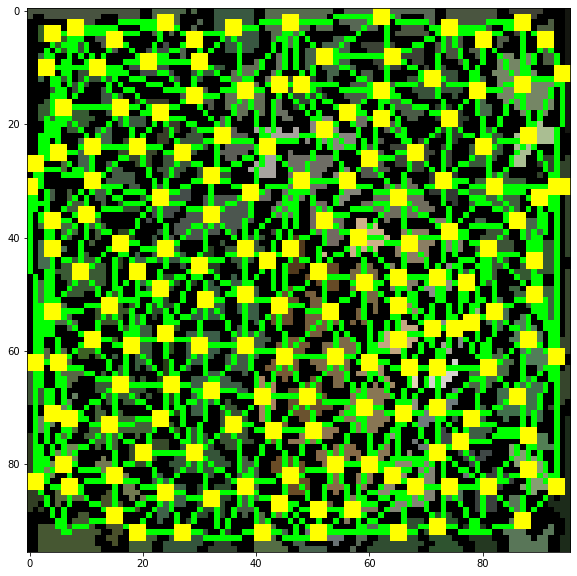

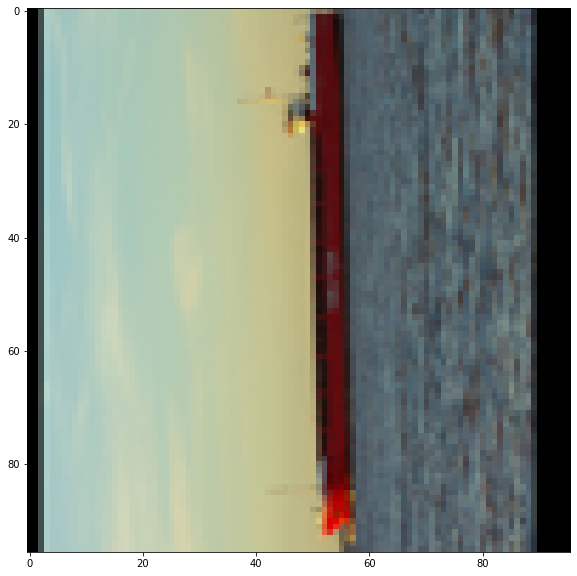

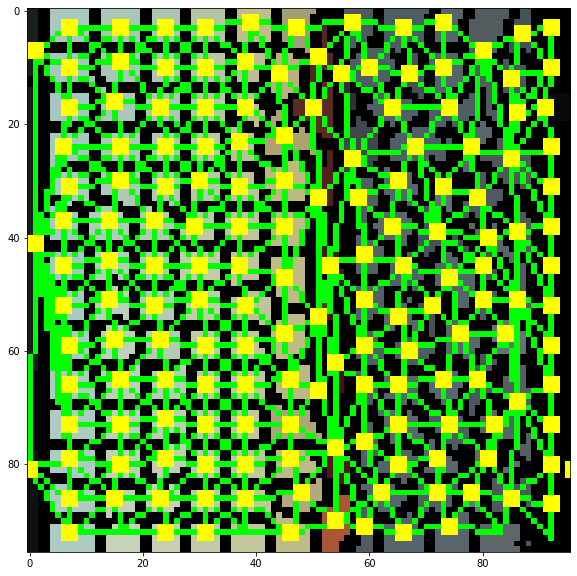

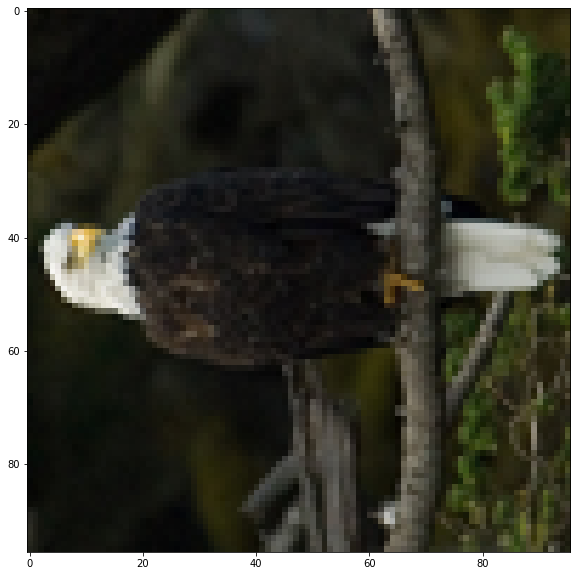

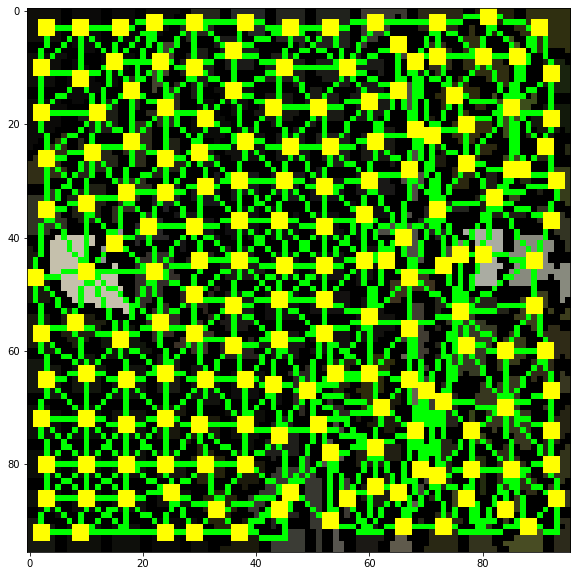

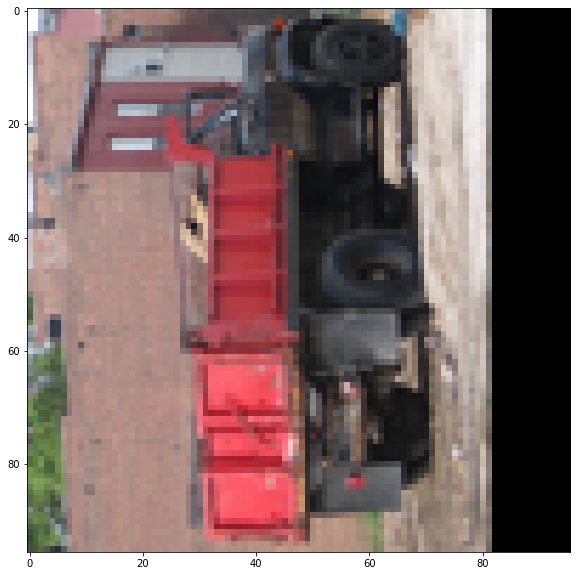

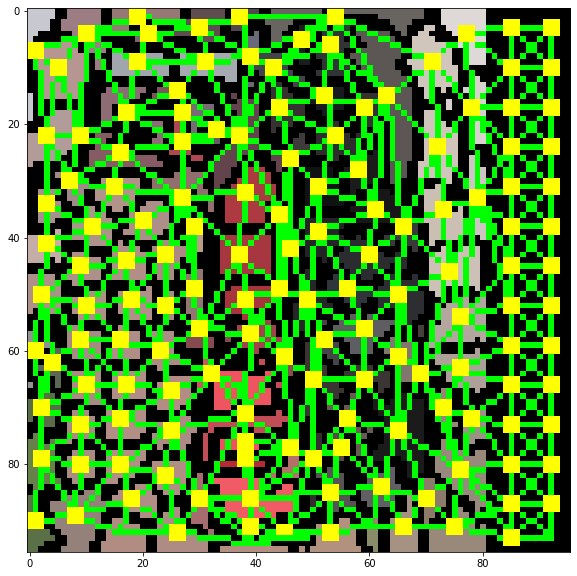

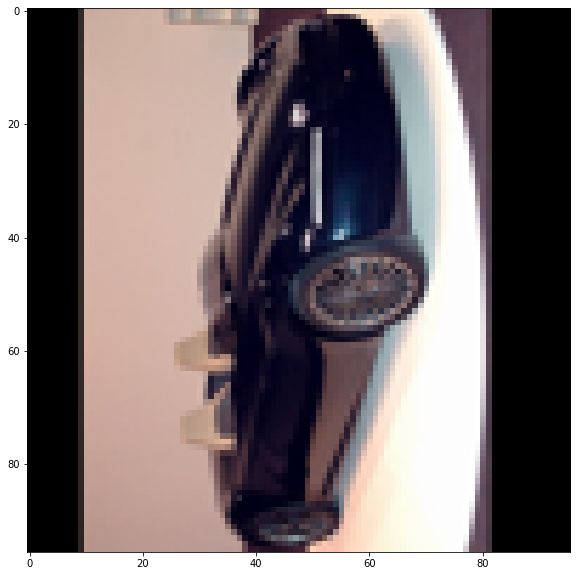

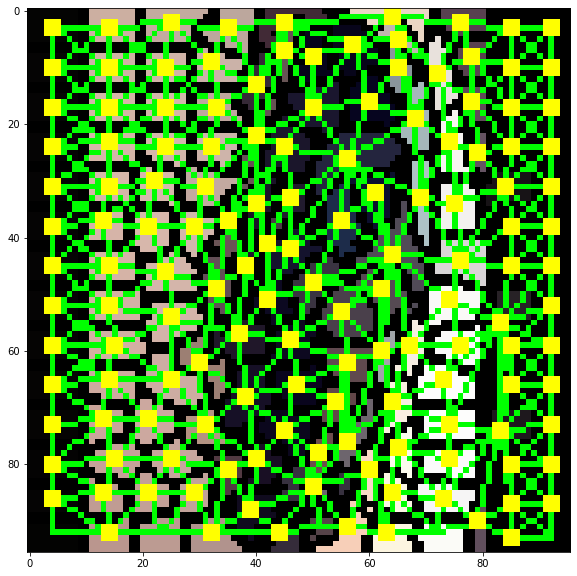

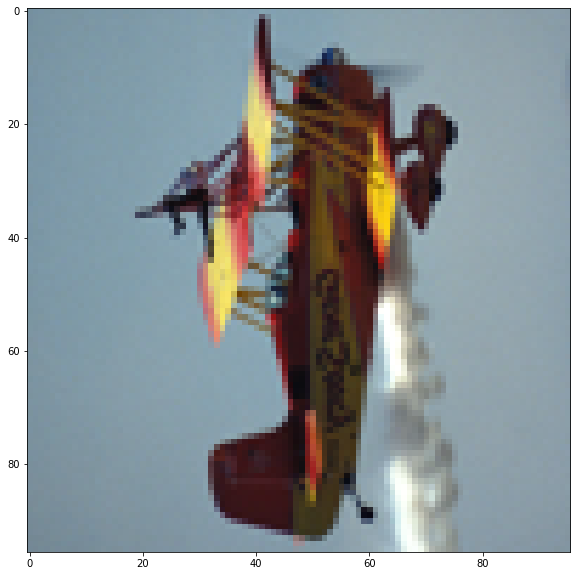

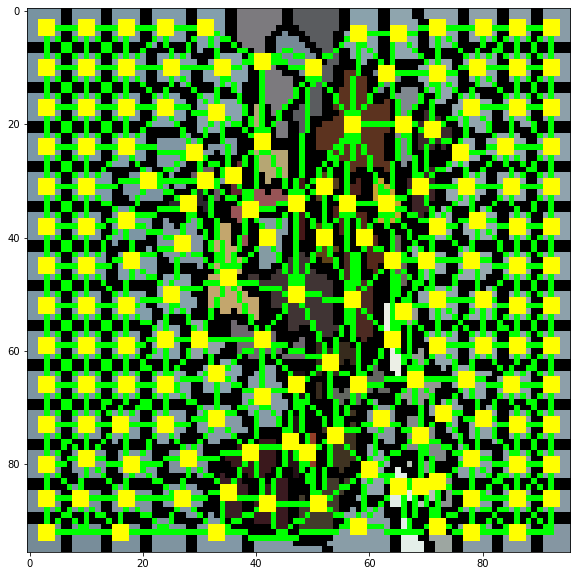

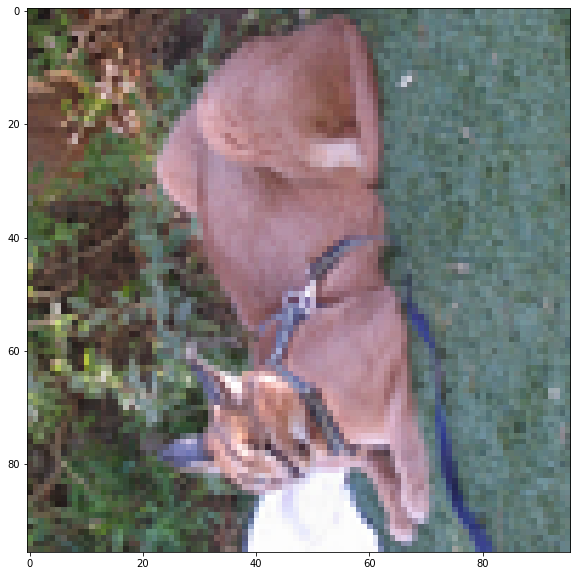

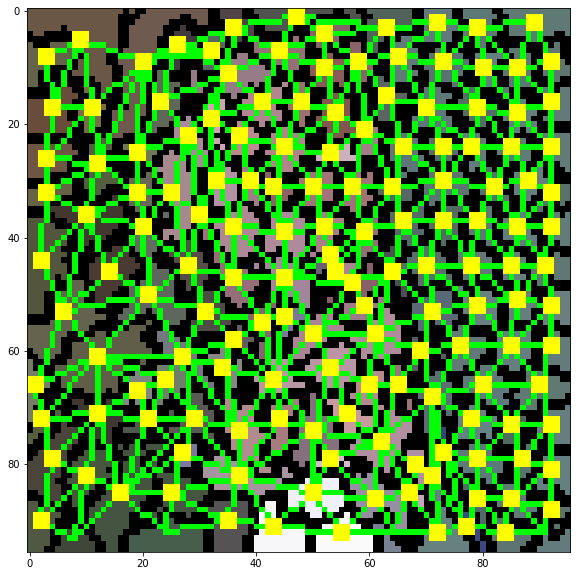

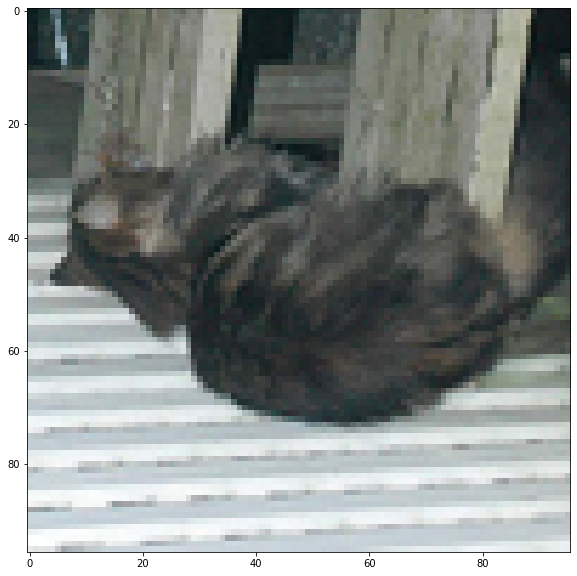

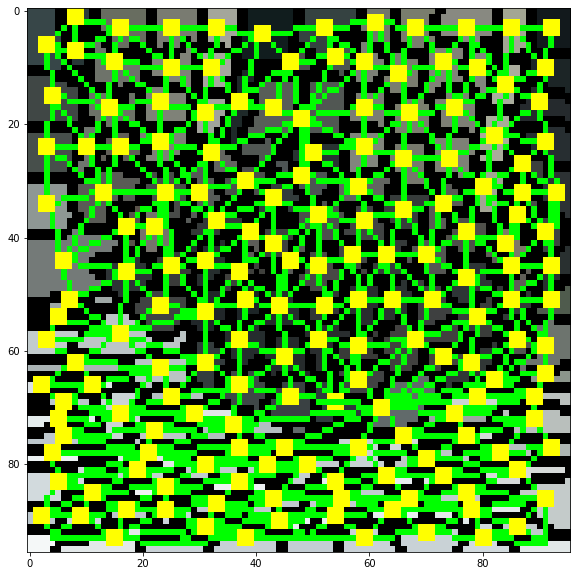

In [ ]:
import torchvision.datasets as datasets
from torchvision import transforms
from torch import nn, optim
import torch
transform = transforms.Compose([transforms.ToTensor()])
#mnist = datasets.QMNIST(root='./data', train=True, download=True, transform=transform)

trainset = datasets.STL10('PATH_TO_STORE_TRAINSET', download=True, transform=transform)
#valset = datasets.CelebA('PATH_TO_STORE_TESTSET', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
#valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

#data_dig = mnist
dataiter = iter(trainloader)
images, labels = dataiter.next()
#print(len(data_dig))
data_skim = data.coins()
#print(data_skim.shape)


#for num in range(len(data_dig.data)):
rags = []
for num in range(10):
#for num in range(len(data)):
  #print(num)
  img = images[num].double().numpy().transpose((2, 1, 0))
  #print(img.shape)
  #print(img.shape)
  #img = data
  #print(img)
  show_img(img)
  labels = segmentation.slic(img, compactness=10, n_segments=200)
  #print(labels)
  labels = labels + 1  # So that no labelled region is 0 and ignored by regionprops
  #print(labels.shape)
  #print(img.shape)
  regions = regionprops(labels,intensity_image=np.zeros((96,96)))
  #print(regions)
  label_rgb = color.label2rgb(labels, img, kind='avg')
  #show_img(label_rgb)
  label_rgb = segmentation.mark_boundaries(label_rgb, labels, (0, 0, 0))
  #show_img(label_rgb)
  #print(label_rgb.shape)


  rag = graph.rag_mean_color(img, labels)
  for region in regions:
    rag.nodes[region['label']]['centroid'] = region['centroid']
    rag.nodes[region['label']]['intensity_image'] = region['intensity_image']
    #print(region['intensity_image'])
    #print(region['centroid'])
    #print(rag.nodes)
  rags.append(rag)
  edges_drawn_all = display_edges(label_rgb, rag, np.inf )
  show_img(edges_drawn_all)

In [ ]:
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
!pip install -q torch-geometric

     |████████████████████████████████| 11.9MB 4.5MB/s 
     |████████████████████████████████| 24.3MB 1.6MB/s 
     |████████████████████████████████| 194kB 5.3MB/s 
     |████████████████████████████████| 235kB 21.5MB/s 
     |████████████████████████████████| 2.2MB 12.5MB/s 
     |████████████████████████████████| 51kB 5.6MB/s 


In [2]:
import torch
#from torch_geometric.datasets import TUDataset
import networkx as nx
from torch_geometric.utils import from_scipy_sparse_matrix, from_networkx
#dataset = nx.to_scipy_sparse_matrix(rags[0])
dataset = []
for i in range(len(rags)):
  dataset.append(from_networkx(rags[i]))
  dataset[i].x = dataset[i].intensity_image
  dataset[i].edge_index = dataset[i].edge_index
  dataset[i].pos = dataset[i].centroid
  # dataset[i].data = dataset[i].intensity_image

#dataset = np.array(dataset)
#dataset = from_networkx(rags[0])
#dataset = torch.Tensor(dataset)
print(dataset)
print()
# print(f'Dataset: {dataset}:')
# print('====================')
print(f'Number of graphs: {len(dataset)}')
#print(f'Number of features: {dataset.num_features}')
#print(f'Number of classes: {dataset.num_classes}')
print(dataset[0].num_node_features)

  # Get the first graph object.
data = dataset[0]
print()
#print(data)
print('=============================================================')

#Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
print(f'Contains self-loops: {data.contains_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

In [ ]:
torch.manual_seed(12345)
#dataset = dataset.shuffle()

train_dataset = dataset
#test_dataset = dataset[150:]

print(f'Number of training graphs: {len(train_dataset)}')
#print(f'Number of test graphs: {len(test_dataset)}')

from torch_geometric.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
#test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    #print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Number of training graphs: 10
Step 1:
Batch(batch=[177], centroid=[177, 2], edge_index=[2, 998], intensity_image=[1], labels=[177, 1], mean color=[177, 3], pixel count=[177], pos=[177, 2], total color=[177, 3], weight=[998], x=[1])

Step 2:
Batch(batch=[156], centroid=[156, 2], edge_index=[2, 850], intensity_image=[1], labels=[156, 1], mean color=[156, 3], pixel count=[156], pos=[156, 2], total color=[156, 3], weight=[850], x=[1])

Step 3:
Batch(batch=[164], centroid=[164, 2], edge_index=[2, 918], intensity_image=[1], labels=[164, 1], mean color=[164, 3], pixel count=[164], pos=[164, 2], total color=[164, 3], weight=[918], x=[1])

Step 4:
Batch(batch=[179], centroid=[179, 2], edge_index=[2, 980], intensity_image=[1], labels=[179, 1], mean color=[179, 3], pixel count=[179], pos=[179, 2], total color=[179, 3], weight=[980], x=[1])

Step 5:
Batch(batch=[161], centroid=[161, 2], edge_index=[2, 936], intensity_image=[1], labels=[161, 1], mean color=[161, 3], pixel count=[161], pos=[161, 2],

In [ ]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(163, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, 1)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

model = GCN(hidden_channels=64)
print(model)

GCN(
  (conv1): GCNConv(163, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=1, bias=True)
)


In [1]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GCN(hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()


print(dataset[0])
def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         print(data)
         out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test(loader):
     model.eval()

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         out = model(data.x, data.edge_index, data.batch)  
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.


for epoch in range(1, 201):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')#